In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
%matplotlib inline

In [4]:
drivers_pd = pd.read_csv("data/driver_imgs_list.csv")

In [9]:
drivers_pd.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# 分析
## 数据探索

数据集来源于往年的Kaggle竞赛。数据集中包含大量车载摄像头对驾驶员位置的摄影截图，可清楚看到驾驶员的各种行为，包括打电话、喝饮料、拿后面的东西、打字等。

数据集中将图片数据分为了训练集和测试集，训练集可用于该项目中训练模型，测试集可在模型训练完毕后检验预测效果，可提交至Kaggle中计算已训练模型的最终得分。

训练集中已将图像标记分类，分为c0到c9一共十个文件夹存放，共22424张图片。测试集中有79729张未标记分类的图片。

In [6]:
drivers_pd.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_80036.jpg
freq,1237,2489,1


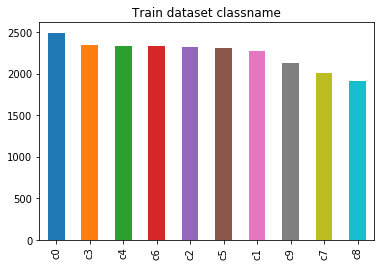

In [13]:
drivers_pd["classname"].value_counts().plot(kind="bar", title="Train dataset classname")

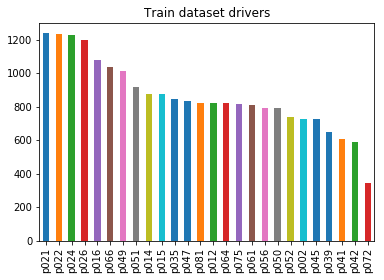

In [14]:
drivers_pd["subject"].value_counts().plot(kind="bar", title="Train dataset drivers")

从数据集中的driver_imgs_list.csv文件中可得处一些关于该数据集的信息：
- 总共有22424张已标记图像
- 总共有26名驾驶员的不同状态的图像，每名驾驶员的图像数量并不完全相同，最多的驾驶员有1237张图像，最少的驾驶员只有346张图像
- 总共有10种不同的驾驶状态，且每种状态的图片数量差别不大，即它们呈均匀分布

In [7]:
drivers_pd["subject"].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

这里因为数据集中的司机图像是从视频中截取出来的，可能存在两张甚至多种几乎一样的图像分别位于训练集和验证集中。训练后做验证时因为验证集存在几乎相同的图像，会导致验证分数被提高，但实际上模型仅仅是记住了该图片，因此分割验证集里需要采用一些策略。

决定使用sklearn中的`GroupKFold`对数据集进行划分，划分时使用`subject`列中的数据作为分组依据，`img`列和`classname`列分别作为数据的特征和目标分类。

In [12]:
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
group_kfold = GroupKFold(n_splits=13)
group_kfold.get_n_splits(imgs_pd, class_pd, subject_pd)

13

这里将数据集划分为13组，每组拥有2名驾驶员的图像数据

## 探索性可视化

数据集中每一张图片大小为640*480像素。图片中的驾驶员各种各样，有胖有瘦，有高有矮，有男有女、甚至还有不同肤色的驾驶员，有的驾驶员手臂上还有纹身。图片的光线有明，也有暗，甚至还有些有点爆光过度，导致难以发现手中的透明杯子。

In [16]:
import imageio

因光照原因，看不见手中的水杯

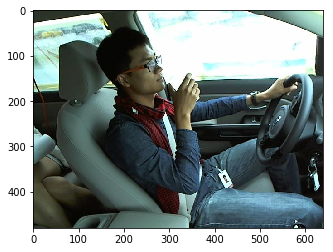

In [19]:
img = imageio.imread("data/imgs/train/c6/img_16.jpg")
plt.imshow(img)
plt.show()

非常胖的驾驶员

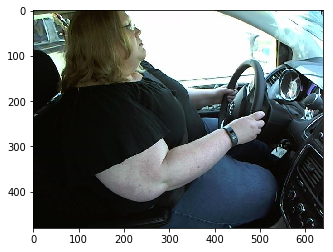

In [20]:
img = imageio.imread("data/imgs/train/c0/img_104.jpg")
plt.imshow(img)
plt.show()

图像模糊

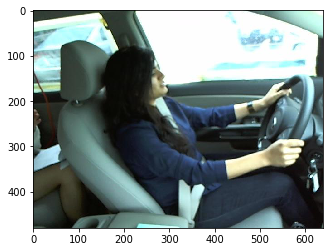

In [21]:
img = imageio.imread("data/imgs/train/c0/img_316.jpg")
plt.imshow(img)
plt.show()

## 算法和技术
### Tensorflow
Tensorflow是一个Google公司开发的基于数据流图计算的人工智能神经网络处理框架，可广泛应用于如语音识别，自然语言理解，计算机视觉，广告等。
### Keras
Keras是一个高层神经网络API，基于tensorflow、Theano以及CNTK后端框架的上层框架，让tensorflow等基础神经网络框架更易于使用。
### 数据增强
由于图像有明有暗，司机在图像中所处的位置也不同，甚至有些图片比较模糊，决定在训练之前对分割出的训练图像和验证图像做数据增强处理。

数据增强是将图片变换处理出多式多样的不同副本，图像中的主要内容不变，但经过数据增强预处理的图像会被挤压、缩小、旋转角度、添加噪点、Dropout、模糊处理、提升亮度、降低亮度等，将图像这样预处理后模型将有机会认识到图像的各种形态，增加模型的鲁棒性和泛化能力。

这里将尝试使用Keras中的图像预处理器对任意挑选的一张图片做预处理实验

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

img = load_img('data/imgs/train/c0/img_316.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/imgs/preview', save_prefix='c0', save_format='jpeg'):
    i += 1
    if i > 20:
        break

KeyboardInterrupt: 

In [48]:
kfolds = group_kfold.split(imgs_pd, class_pd, subject_pd)
for train_index, test_index in kfolds:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = imgs_pd[train_index], imgs_pd[test_index]
    y_train, y_test = class_pd[train_index], class_pd[test_index]
    print(X_train, X_test, y_train, y_test)

TRAIN: [    0     1     2 ... 22421 22422 22423] TEST: [ 4377  4378  4379 ... 20784 20785 20786]
0        img_44733.jpg
1        img_72999.jpg
2        img_25094.jpg
3        img_69092.jpg
4        img_92629.jpg
5         img_3370.jpg
6        img_67639.jpg
7        img_58560.jpg
8        img_35779.jpg
9        img_10012.jpg
10       img_70354.jpg
11       img_54617.jpg
12       img_26684.jpg
13       img_82409.jpg
14        img_5585.jpg
15       img_19029.jpg
16       img_40930.jpg
17       img_31547.jpg
18       img_87373.jpg
19       img_10627.jpg
20       img_66355.jpg
21       img_97714.jpg
22       img_37344.jpg
23       img_54848.jpg
24       img_59964.jpg
25       img_70675.jpg
26       img_43317.jpg
27       img_13585.jpg
28       img_63064.jpg
29       img_91058.jpg
             ...      
22394    img_77168.jpg
22395    img_13314.jpg
22396    img_65995.jpg
22397    img_32115.jpg
22398    img_20671.jpg
22399    img_13398.jpg
22400    img_39400.jpg
22401    img_22164.jpg
22402 